<a href="https://colab.research.google.com/github/sabahoth01/Computer-vision-course/blob/main/PPE_Detection_using_sh17_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!/usr/local/cuda/bin/nvcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sat Dec 28 08:09:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              11W /  7

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,

import kagglehub
mugheesahmad_sh17_dataset_for_ppe_detection_path = kagglehub.dataset_download('mugheesahmad/sh17-dataset-for-ppe-detection')
makhloufimohamed_safety_helmet_test_dataset_path = kagglehub.dataset_download('makhloufimohamed/safety-helmet-test-dataset')

print('Data source import complete.')


100%|██████████| 13.1G/13.1G [06:16<00:00, 37.4MB/s]

Extracting files...


100%|██████████| 18.6M/18.6M [00:01<00:00, 17.7MB/s]

Extracting files...


Data source import complete.


# PPE Detection Workflow

## 1. Exploratory Data Analysis (EDA)

### Import Libraries

In [ ]:
import os
import random
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import pandas as pd
from glob import glob

### Load and Explore the Dataset

In [ ]:
import os

# Create the {HOME}/yolov9/dataset directory if it doesn't exist
os.makedirs('/content/PPE/dataset', exist_ok=True)

# Define the source and destination paths
source_path = '/root/.cache/kagglehub/datasets/mugheesahmad/sh17-dataset-for-ppe-detection/versions/1'
destination_path = '/content/PPE/dataset'

# Copy the dataset files to the /content/data directory
!cp -r "{source_path}/." "{destination_path}/"

# Verify the files have been copied
print("Files in /content/PPE/dataset:")
!ls /content/PPE/dataset

Files in /content/PPE/dataset:
images	labels	meta-data  train_files.txt  val_files.txt  voc_labels


In [ ]:
import os

# Dataset path
# BASE_PATH = "/kaggle/input/sh17-dataset-for-ppe-detection"
BASE_PATH = "/content/PPE/"
print(os.listdir(BASE_PATH))


['dataset']


In [ ]:

# Paths
IMAGES_PATH = os.path.join(BASE_PATH, "dataset/images")
LABELS_PATH = os.path.join(BASE_PATH, "dataset/labels")
TRAIN_FILES = os.path.join(BASE_PATH, "dataset/train_files.txt")
VAL_FILES = os.path.join(BASE_PATH, "dataset/val_files.txt")

In [ ]:
def list_files_in_folder(folder_path, extension):
    """List all files with a specific extension in a folder."""
    return sorted(glob(os.path.join(folder_path, f"*.{extension}")))

def load_metadata(metadata_path):
    """Load metadata JSON file."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

def load_label(label_path):
    """Load YOLO label file and parse it."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [line.strip().split() for line in lines]

### Analyze All Class Distribution

* 0: person
* 1: ear
* 2: ear-mufs
* 3: face
* 4: face-guard
* 5: face-mask
* 6: foot
* 7: tool
* 8: glasses
* 9: gloves
* 10: helmet
* 11: hands
* 12: head
* 13: medical-suit
* 14: shoes
* 15: safety-suit
* 16: safety-vest

In [ ]:

def analyze_class_distribution(labels_folder):
    """Analyze class distribution across all labels."""

    labels = list_files_in_folder(labels_folder, 'txt')

    class_instance_counter = Counter()
    class_image_counter = Counter()

    for label_file in labels:
        annotations = load_label(label_file)
        tmp_set = set()
        for annotation in annotations:
            class_id = annotation[0]
            class_instance_counter[class_id] += 1
            if class_id not in tmp_set :
                class_image_counter[class_id] += 1
                tmp_set.add(class_id)

    # Create first DataFrame with instance counts
    df = pd.DataFrame(class_instance_counter.items(), columns=['Class_ID', 'Count Instances'])
    df['Class_ID'] = df['Class_ID'].astype(int)
    df = df.sort_values('Class_ID')

    # Create second DataFrame with image counts
    df_img_count = pd.DataFrame(class_image_counter.items(), columns=['Class_ID', 'Count Images'])
    df_img_count['Class_ID'] = df_img_count['Class_ID'].astype(int)
    df_img_count = df_img_count.sort_values('Class_ID')

    # Merge the DataFrames on Class_ID
    combined_df = pd.merge(df, df_img_count, on='Class_ID', how='outer')

    # Sort by Class_ID and reset index
    combined_df = combined_df.sort_values('Class_ID').reset_index(drop=True)

    return combined_df

Count the number of instances for each class and the number of images containing each class.

In [ ]:

class_df = analyze_class_distribution(LABELS_PATH)
class_df.head()

Class_ID  Count Instances  Count Images
0         0            13802          7617
1         1             7730          4884
2         2              318           223
3         3             8950          5646
4         4              134           127

In [ ]:
def plot_class_distribution(df, class_names, figsize=(12, 6)):
    """Plot class distribution with percentages and colors."""
    # Calculate percentages
    total = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total * 100).round(1)

    # Sort the DataFrame by counts in descending order
    df = df.sort_values('Count', ascending=False)

    # Map class IDs to their names
    df['Class_Name'] = df['Class_ID'].map(lambda x: class_names[int(x)])

    # Create the plot
    plt.figure(figsize=figsize)
    colors = sns.color_palette("husl", len(df))
    barplot = sns.barplot(
        x='Class_Name',
        y='Count',
        data=df,
        palette=colors
    )

    # Add percentage labels above the bars
    for i, row in enumerate(df.itertuples()):
        barplot.text(
            i,
            row.Count + total * 0.003,
            f"{row.Percentage}%",
            ha='center',
            fontsize=10,
            color='black'
        )

    # Add labels and title
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Instances", fontsize=12)
    plt.title("Class Distribution with Percentages", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<ipython-input-10-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


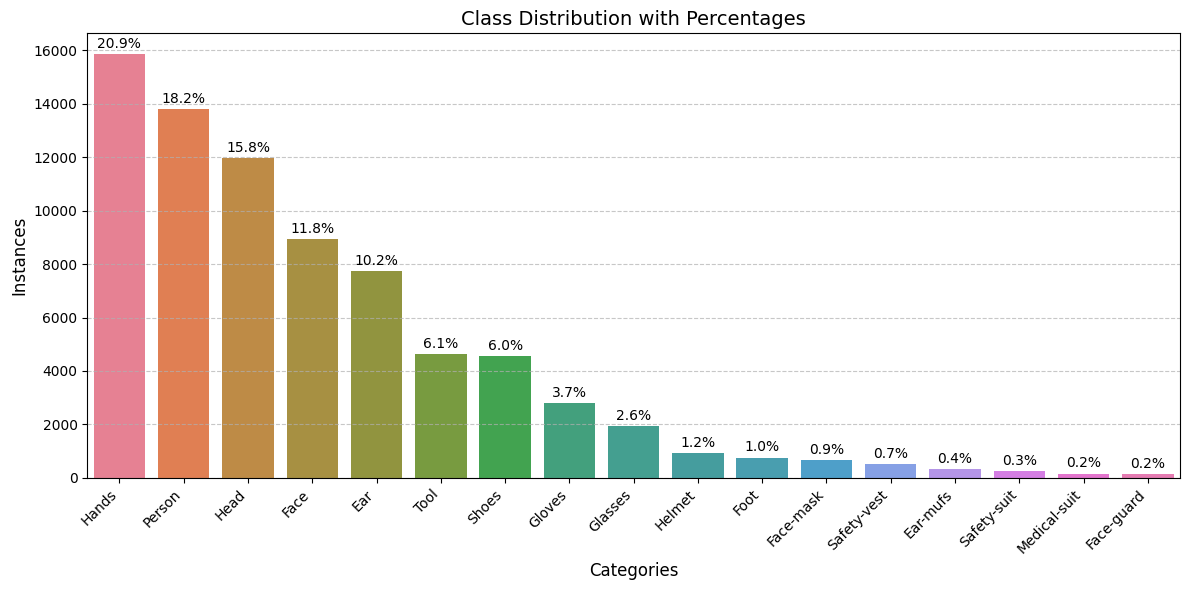

In [ ]:
class_names = [
    "Person", "Ear", "Ear-mufs", "Face", "Face-guard", "Face-mask",
    "Foot", "Tool", "Glasses", "Gloves", "Helmet", "Hands", "Head",
    "Medical-suit", "Shoes", "Safety-suit", "Safety-vest"
]
plot_class_distribution(class_df.rename(columns={'Count Instances': 'Count'}), class_names)

Visualize a sample of the data with annotations.

In [ ]:
def visualize_annotations(image_path, label_path, title=''):
    """Display an image with its bounding boxes."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = load_label(label_path)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation)
        h, w, _ = img.shape
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, str(int(class_id)), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


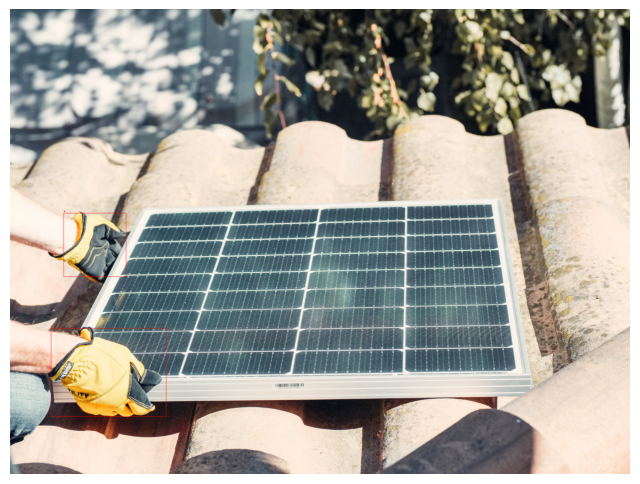

In [ ]:
sample_image = f'{IMAGES_PATH}/pexels-photo-9875413.jpeg'
sample_label = f'{LABELS_PATH}/pexels-photo-9875413.txt'
visualize_annotations(sample_image, sample_label)


Zoom in on the class distribution to show only the person, helmet, and safety vest classes.

<ipython-input-10-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


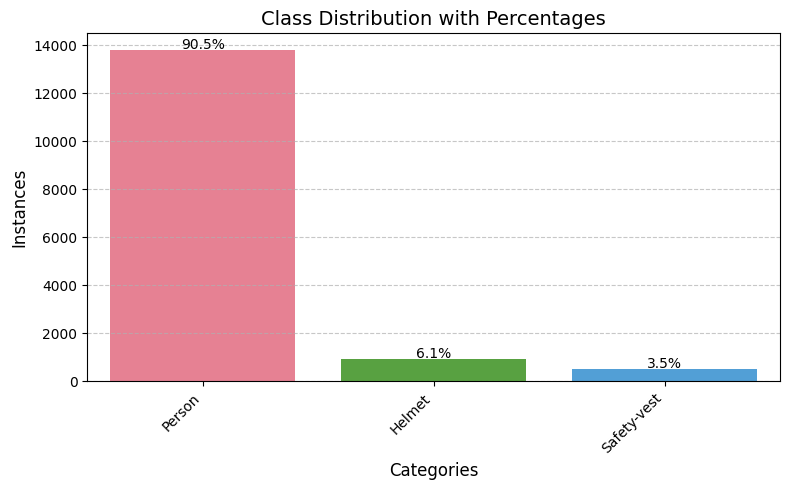

In [ ]:
filtered_df = class_df[class_df['Class_ID'].isin([0, 10, 16])].copy()
plot_class_distribution(filtered_df.rename(columns={'Count Instances': 'Count'}), class_names, figsize=(8, 5))

## 2. Dataset Filtering

In [ ]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/content/PPE/working/dataset/images/train", exist_ok=True)
os.makedirs("/content/PPE/working/dataset/images/val", exist_ok=True)
os.makedirs("/content/PPE//working/dataset/labels/train", exist_ok=True)
os.makedirs("/content/PPE/working/dataset/labels/val", exist_ok=True)

# Classes to retain: person (0), helmet (10), safety-vest (16)
TARGET_CLASSES = [0, 10, 16]

# Helper function to filter labels and move corresponding images
def filter_and_move(file_list, dest_images, dest_labels):
    with open(file_list, "r") as f:
        file_names = f.read().strip().split("\n")
    number_skip, number_move = 0, 0

    for file_name in file_names:
        base_name = os.path.splitext(file_name)[0]

        # Paths for source image and label
        img_src = os.path.join(IMAGES_PATH, file_name)
        label_src = os.path.join(LABELS_PATH, f"{base_name}.txt")

        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        # Read and filter label file
        filtered_lines = []
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                if int(class_id) in TARGET_CLASSES:
                    # Map old class ID to new class ID (0, 1, 2)
                    new_class_id = TARGET_CLASSES.index(int(class_id))
                    filtered_lines.append(f"{new_class_id} {' '.join(bbox)}\n")  # Added \n here

        # Skip if no valid annotations remain
        if len(filtered_lines) == 0:
            number_skip += 1
            continue

        number_move += 1

        # Save filtered label
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        with open(label_dest, "w") as outfile:
            outfile.writelines(filtered_lines)  # Now each line has proper line ending

        # Copy corresponding image
        shutil.copy2(img_src, os.path.join(dest_images, file_name))  # Fixed image copy path

    print(f"{number_skip} images skipped, and {number_move} were moved")

In [ ]:
# Process training and validation datasets
filter_and_move(TRAIN_FILES,
                "/content/PPE/working/dataset/images/train",
                "/content/PPE/working/dataset/labels/train")



365 images skipped, and 6114 were moved


In [ ]:
filter_and_move(VAL_FILES,
                "/content/PPE/working/dataset/images/val",
                "/content/PPE/working/dataset/labels/val")

100 images skipped, and 1520 were moved


In [ ]:
filtered_class_df = analyze_class_distribution('/content/PPE/working/dataset/labels/train')
filtered_class_df.head()

Class_ID  Count Instances  Count Images
0         0            11068          6102
1         1              773           373
2         2              433           168

In [ ]:
filtered_class_df_val = analyze_class_distribution('/content/PPE/working/dataset/labels/val')
filtered_class_df_val.head()

Class_ID  Count Instances  Count Images
0         0             2734          1515
1         1              154            93
2         2               97            45

<ipython-input-10-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


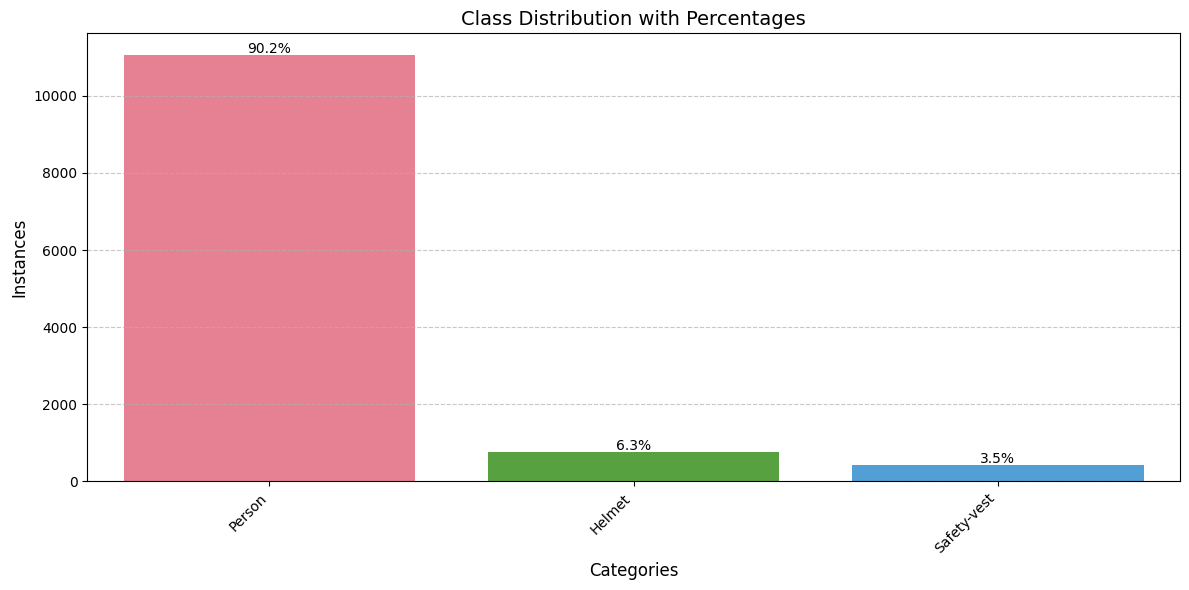

In [ ]:
safety_class_names = [
    "Person", "Helmet","Safety-vest"
]
plot_class_distribution(filtered_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

## 3. Imbalanced Data

In [ ]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/content/PPE/working/undersampled_dataset/images/train", exist_ok=True)
os.makedirs("/content/PPE/working/undersampled_dataset/images/val", exist_ok=True)
os.makedirs("/content/PPE/working/undersampled_dataset/labels/train", exist_ok=True)
os.makedirs("/content/PPE/working/undersampled_dataset/labels/val", exist_ok=True)

def undersampled_person_data( images_path, labels_path, dest_images, dest_labels, person_count):

    file_names = os.listdir(images_path)

    i= 0
    for file_name in file_names:

        base_name = os.path.splitext(file_name)[0]

        # Paths for source image and label
        img_src = os.path.join(images_path, file_name)
        label_src = os.path.join(labels_path, f"{base_name}.txt")

        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        filtered_lines = set()
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                filtered_lines.add(int(class_id))

        filtered_lines = list(filtered_lines)

        if len(filtered_lines) == 1 and filtered_lines[0] == 0 and i>= person_count:
            continue
        if len(filtered_lines) == 1 and filtered_lines[0] == 0:
            i+=1

        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        shutil.copy2(label_src, label_dest)

        # Copy corresponding image
        shutil.copy2(img_src, dest_images)




In [ ]:
undersampled_person_data("/content/PPE/working/dataset/images/train",
                "/content/PPE/working/dataset/labels/train",
                "/content/PPE/working/undersampled_dataset/images/train",
                "/content/PPE/working/undersampled_dataset/labels/train", 90)

In [ ]:
undersampled_class_df = analyze_class_distribution('/content/PPE/working/undersampled_dataset/labels/train')
undersampled_class_df.head()

Class_ID  Count Instances  Count Images
0         0             1308           500
1         1              773           373
2         2              433           168

<ipython-input-10-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


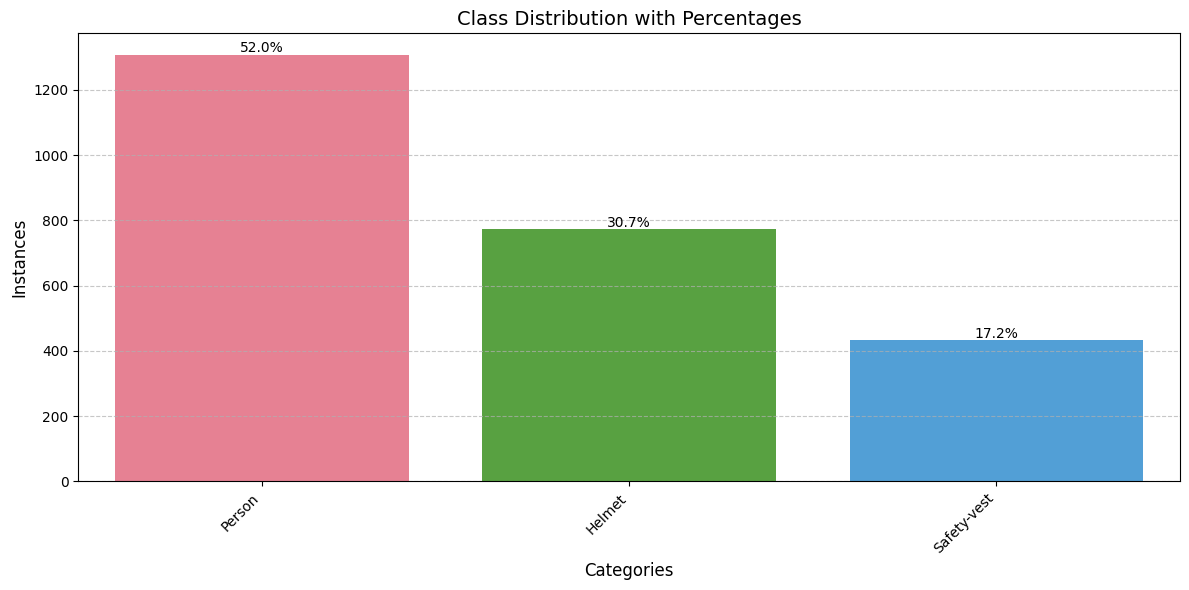

In [ ]:
plot_class_distribution(undersampled_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

In [ ]:
undersampled_person_data("/content/PPE/working/dataset/images/val",
                "/content/PPE/working/dataset/labels/val",
                "/content/PPE/working/undersampled_dataset/images/val",
                "/content/PPE/working/undersampled_dataset/labels/val", 30)

In [ ]:
undersampled_class_df_val = analyze_class_distribution('/content/PPE/working/undersampled_dataset/labels/val')
undersampled_class_df_val.head()

Class_ID  Count Instances  Count Images
0         0              309           131
1         1              154            93
2         2               97            45

## 4. Model Training

In [ ]:
%pip install ultralytics==8.0.38

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 17.9 MB/s eta 0:00:00


In [ ]:
data_yaml = """
train: /content/PPE/working/undersampled_dataset/images/train
val: /content/PPE/working/undersampled_dataset/images/val
names:
  0: person
  1: helmet
  2: safety-vest
"""

with open("/content/PPE/working/data.yaml", "w") as f:
    f.write(data_yaml)


Download test_dataset images and videos to test the dataset

In [ ]:
# Step 1: Install gdown
!pip install gdown

# Step 2: Download the folder to the specified directory
import os
import gdown

# Create the target directory if it doesn't exist
os.makedirs('/content/PPE', exist_ok=True)

# Change the current working directory
os.chdir('/content/PPE')

# Replace with your folder ID
folder_id = '15qvwLoTF9IXxVGt12D4pnLd7Vi3CxLkm'
gdown.download_folder(f'https://drive.google.com/drive/folders/{folder_id}', quiet=False)

In [ ]:
from ultralytics import YOLO
model = YOLO(r"yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
Device Name: Tesla T4


In [ ]:
model.train(data="/content/PPE/working/data.yaml",\
            project="/content/PPE/working/runs",\
            batch = 4, epochs=40, imgsz = 640, cache=True)

Ultralytics YOLOv8.0.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/PPE/working/data.yaml, epochs=40, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/PPE/working/runs, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, ke

In [ ]:
model = YOLO('/content/PPE/working/runs/train/weights/best.pt')
model.export(format='onnx')


Ultralytics YOLOv8.0.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from /content/PPE/working/runs/train/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.9 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.9 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0...
ONNX: export success ✅ 6.6s, saved as /content/PPE/working/runs/train/weights/best.onnx (11.7 MB)

Export complete (7.1s)
Results saved to /content/PPE/working/runs/train/weights
Predict:         yolo task=detect mode=predict model=/content/PPE/working/runs/train/weights/best.onnx imgsz=640
Validate:        yolo task=detect mode=val model=/content/PPE/working/runs

'/content/PPE/working/runs/train/weights/best.onnx'

## 5. Evaluation

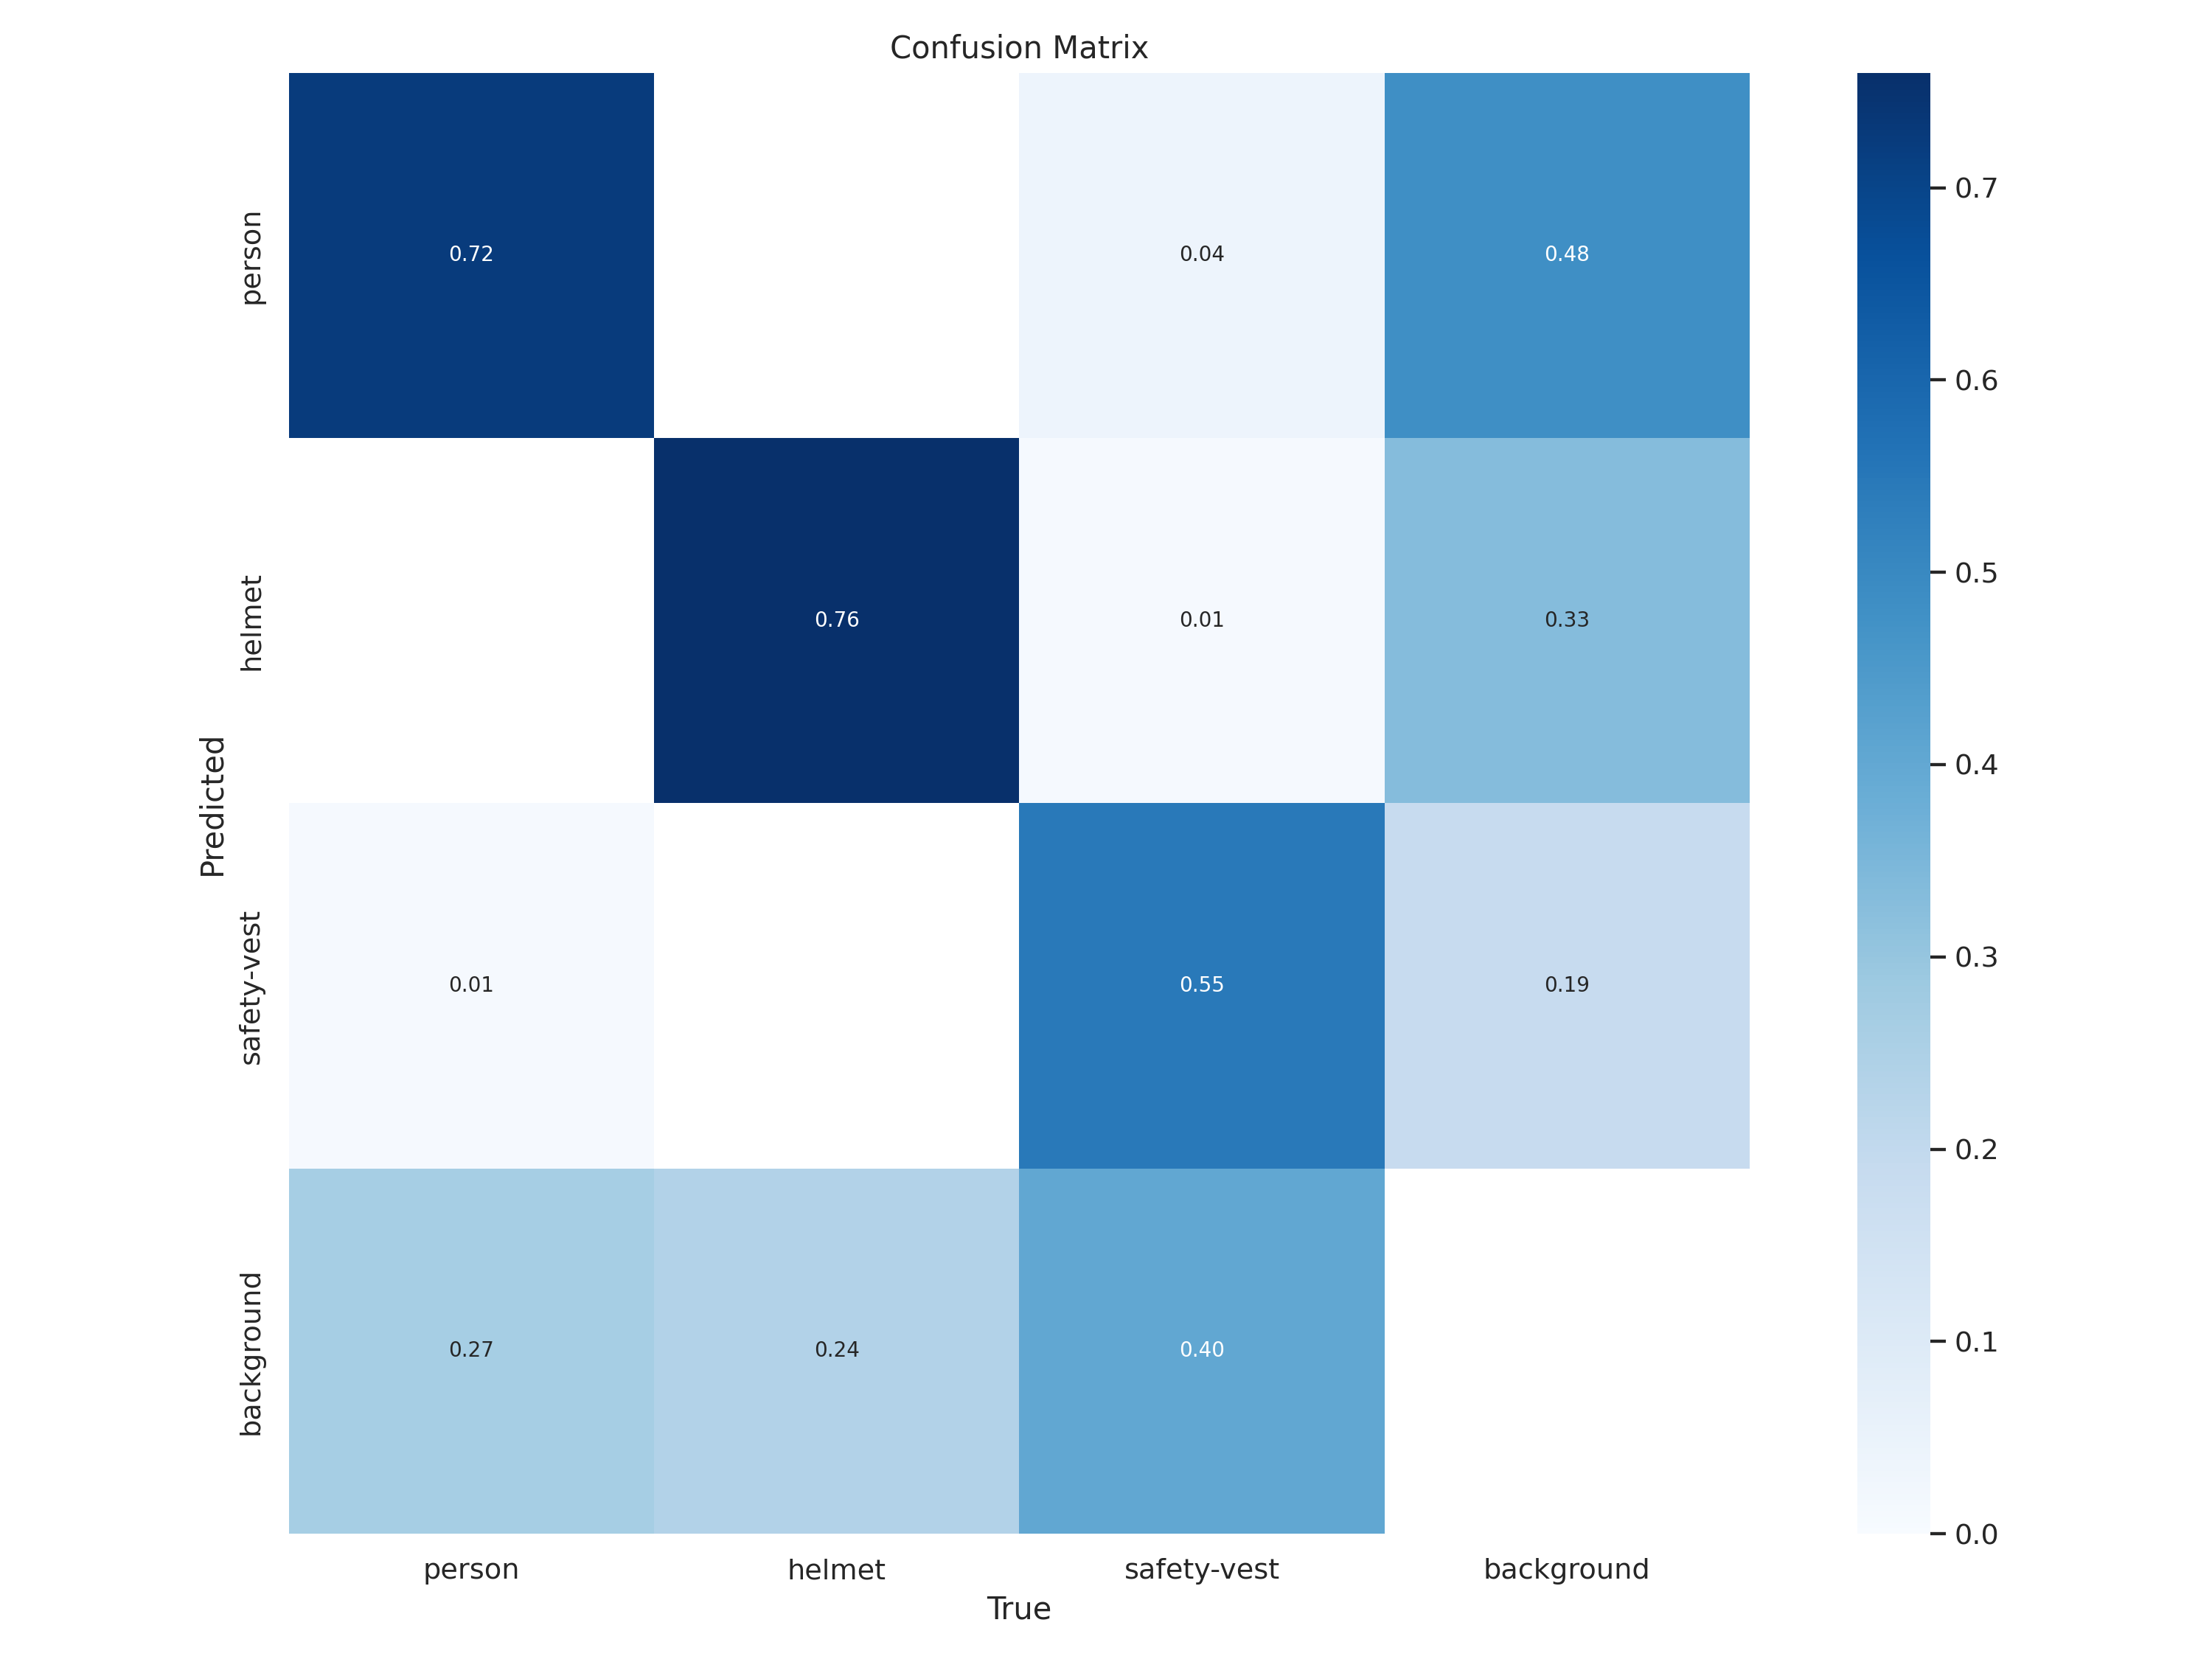

In [ ]:
from IPython.display import Image
Image(filename='/content/PPE/working/runs/train/confusion_matrix.png', width=800)

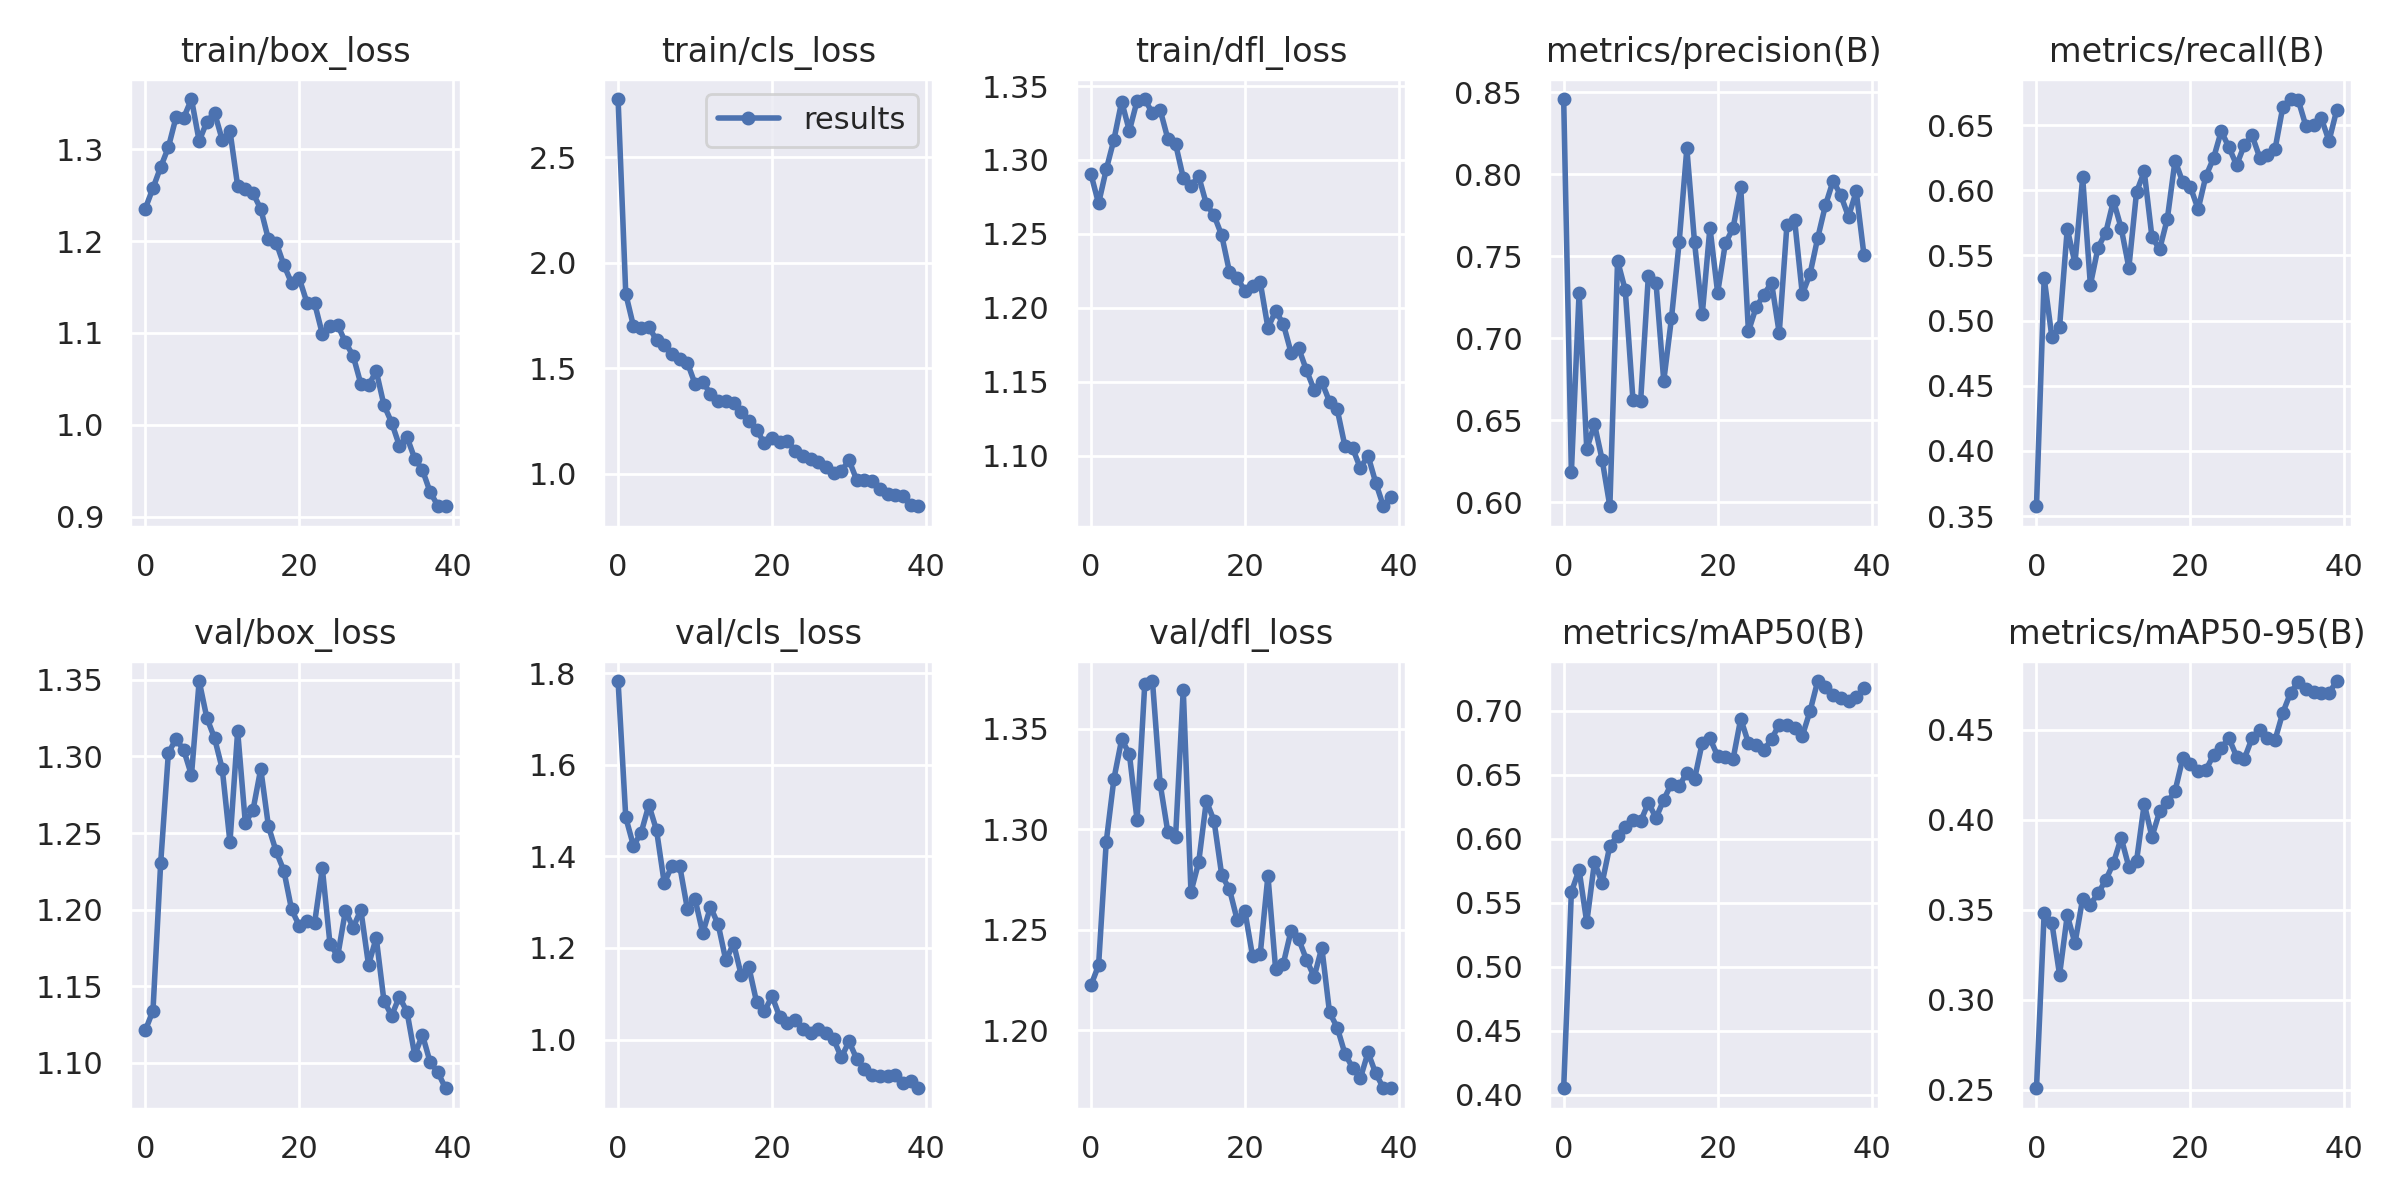

In [ ]:
Image(filename='/content/PPE/working/runs/train/results.png', width=800)

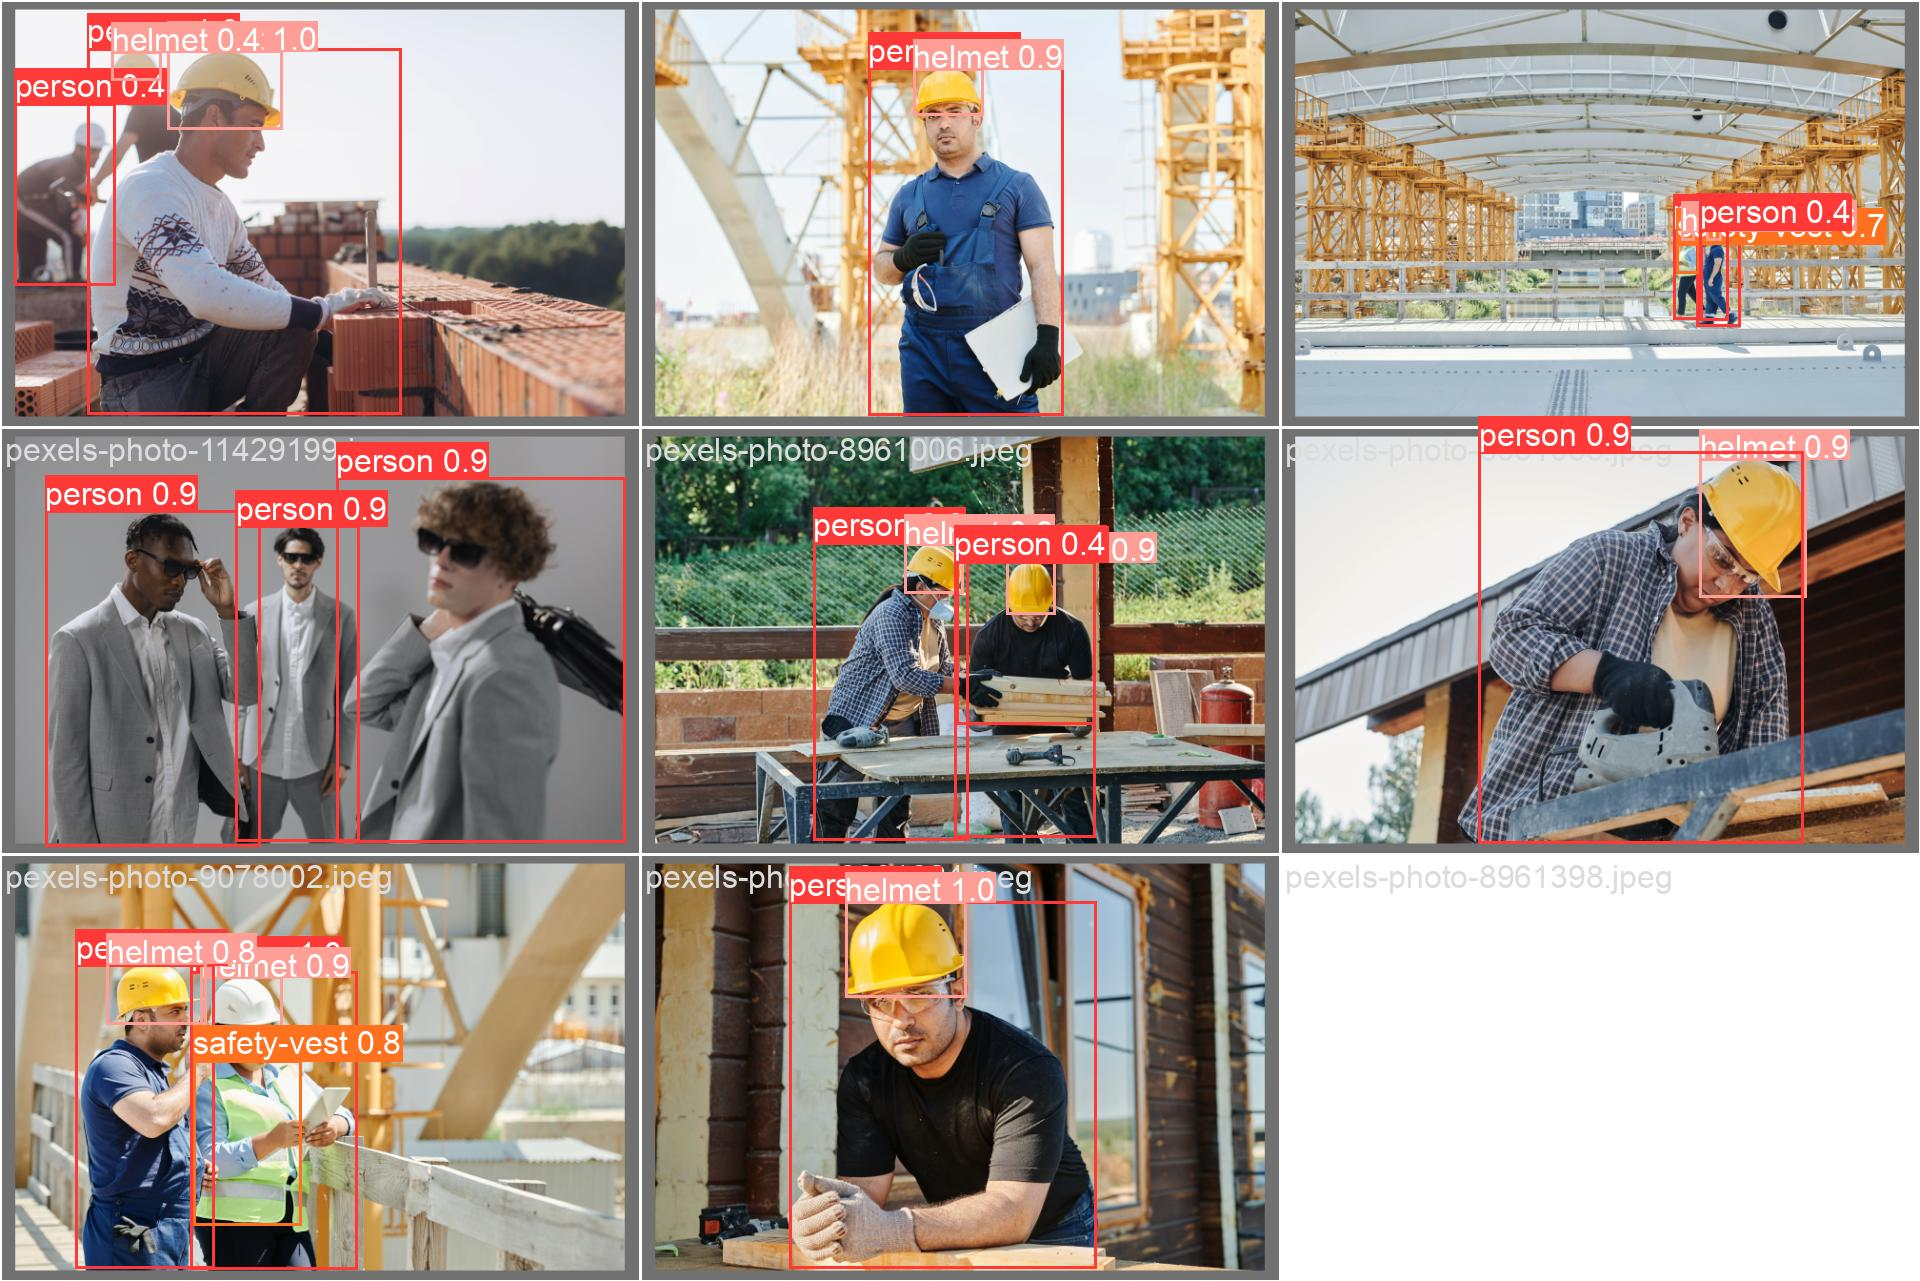

In [ ]:
Image(filename='/content/PPE/working/runs/train/val_batch2_pred.jpg', width=800)

* Test the model with a real image:

* Display a sample test image.
* Show the detected bounding boxes.
* Display the labels corresponding to the detected objects.

Ultralytics YOLOv8.0.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/PPE/test_dataset/ppe-img.png: 640x544 3 persons, 3 helmets, 3 safety-vests, 56.2ms
Speed: 0.6ms pre-process, 56.2ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


9 bounding boxes drawn for /content/PPE/test_dataset/ppe-img.png.


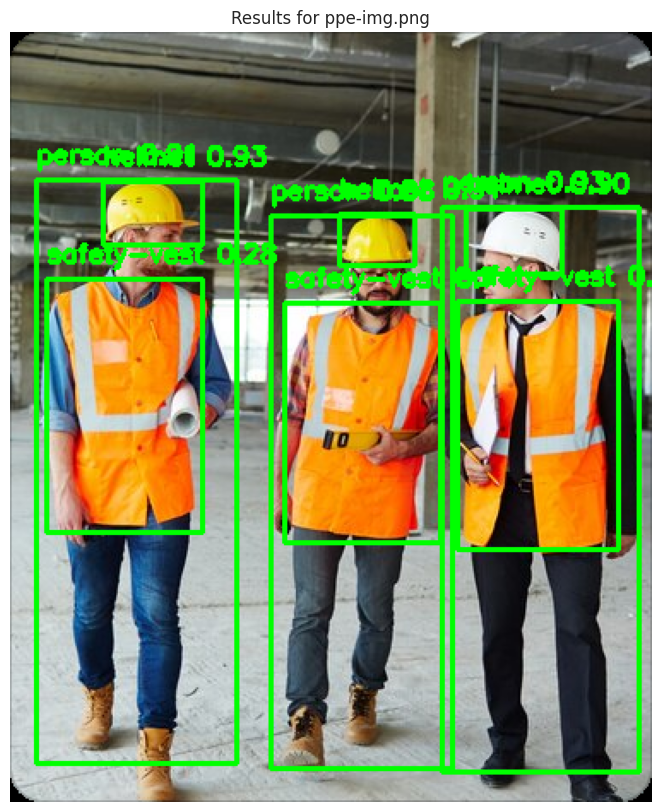


image 1/1 /content/PPE/test_dataset/ppe-img2.jpg: 448x640 7 persons, 2 helmets, 53.6ms
Speed: 0.8ms pre-process, 53.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


9 bounding boxes drawn for /content/PPE/test_dataset/ppe-img2.jpg.


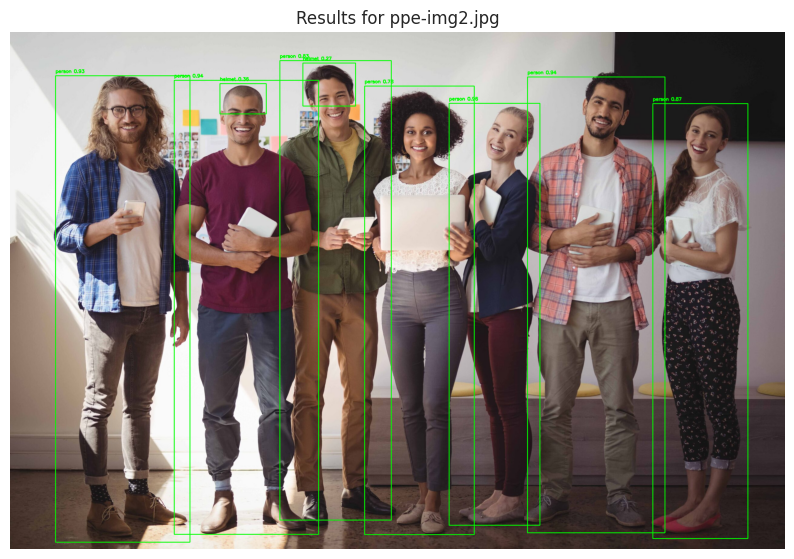


image 1/1 /content/PPE/test_dataset/construction-safety.jpg: 448x640 3 persons, 3 helmets, 3 safety-vests, 10.8ms
Speed: 0.8ms pre-process, 10.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


9 bounding boxes drawn for /content/PPE/test_dataset/construction-safety.jpg.


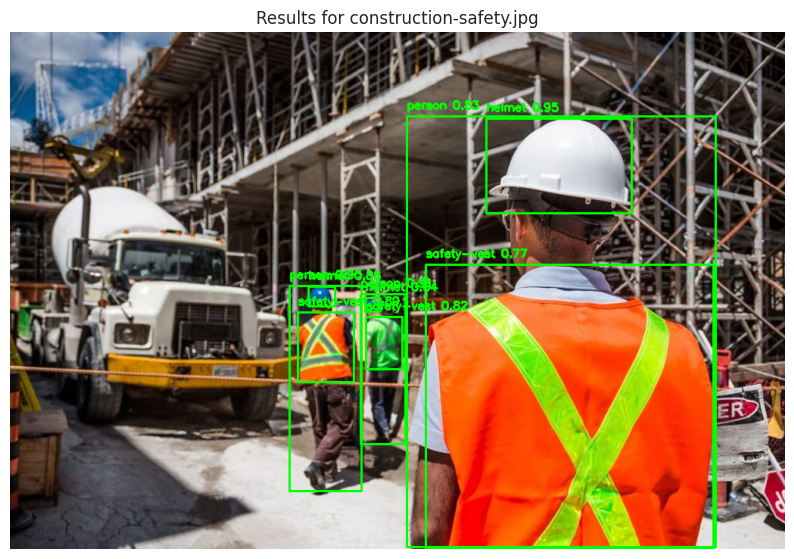

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# List of image paths to test
test_image_paths = [
    '/content/PPE/test_dataset/ppe-img.png',
    '/content/PPE/test_dataset/ppe-img2.jpg',
    '/content/PPE/test_dataset/construction-safety.jpg',
    # Add more image paths as needed
]

# Iterate over each image path
for test_image_path in test_image_paths:
    # Perform inference
    results = model.predict(source=test_image_path, conf=0.25)

    # Check if results are available
    if not results:
        print(f"No detection results found for {test_image_path}.")
        continue

    # Load the image
    image = cv2.imread(test_image_path)

    # Ensure the image is loaded
    if image is None:
        print(f"Failed to load the image: {test_image_path}. Check the file path.")
        continue

    # Draw bounding boxes on the image
    boxes_drawn = 0
    for result in results:
        if not result.boxes:
            print(f"No bounding boxes detected for {test_image_path}.")
            continue

        for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
            x1, y1, x2, y2 = map(int, box)  # Bounding box coordinates
            confidence = float(conf)  # Confidence score
            class_id = int(cls)  # Class ID
            label = f"{model.names[class_id]} {confidence:.2f}"

            # Draw the bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Put the label on the image
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            boxes_drawn += 1

    # Check if any boxes were drawn
    if boxes_drawn == 0:
        print(f"No bounding boxes were drawn for {test_image_path}. Try lowering the confidence threshold or using a different image.")
    else:
        print(f"{boxes_drawn} bounding boxes drawn for {test_image_path}.")

    # Convert the image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Results for {os.path.basename(test_image_path)}")
    plt.show()

## 6. Real-Time Detection

In [ ]:
test_video_path = '/content/PPE/test_dataset/ppe-1.mp4'

# Run the model on the video
results = model.predict(source=test_video_path, conf=0.25, save=True)



video 1/1 (1/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 176.6ms
video 1/1 (2/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 29.0ms
video 1/1 (3/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 28.5ms
video 1/1 (4/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 28.8ms
video 1/1 (5/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 35.0ms
video 1/1 (6/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 43.1ms
video 1/1 (7/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 16.6ms
video 1/1 (8/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 32.3ms
video 1/1 (9/343) /content/PPE/test_dataset/ppe-1.mp4: 384x640 1 person, 1 helmet, 1 safety-vest, 17.2ms
video 1/1 (10/343) /content/PPE/test_dataset/ppe-1.mp

In [ ]:
import cv2

# Path to the video file
video_file = '/content/runs/detect/predict/ppe-1.mp4'

# Open the video file
cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")
    cap.release()

Video opened successfully.


Video с резултата обнаружения  находиться в  **/content/runs/detect/predict/ppe-1.mp4**